Import packages

In [ ]:


import pandas as pd
import numpy as np
import re  
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, TfidfTransformer
tfid = TfidfVectorizer(lowercase= True, stop_words=ENGLISH_STOP_WORDS)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


read data with pandas


In [ ]:
data = pd.read_csv('./data/data.txt', sep=",", header=None)
data.columns = ["bank_transaction_id","bank_transaction_description","bank_transaction_amount","bank_transaction_type"]

In [ ]:
data2 = pd.read_csv('./data/label.txt', sep=",", header=None)
data2.columns = ["bank_transaction_id","bank_transaction_category","bank_transaction_dataset"]

In [ ]:
data['category'] = data2['bank_transaction_category']

In [ ]:
data['bank_transaction_description'] = data['bank_transaction_description'].astype(str)


data['category'] = data['category'].str.lower()
data['bank_transaction_description'] = data['bank_transaction_description'].str.lower()

In [ ]:
del data['bank_transaction_amount']

Check for null values 

In [ ]:
data.isnull().sum()

bank_transaction_id             0
bank_transaction_description    0
bank_transaction_type           0
category                        0
dtype: int64

Fill null value using padding technique(nearest)

In [ ]:
data = data.fillna(method = "pad")

values count of labels

In [ ]:
data.category.value_counts()

accommodation_and_meals    3765
travel                     3166
bank_or_finance_charges    2790
motor_expenses             1609
insurance                  1170
Name: category, dtype: int64

Cleaning function to remove puntutation and other symbols

In [ ]:
import re

def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)
    
  return input_txt
data['bank_transaction_description'] = np.vectorize(remove_pattern)(data['bank_transaction_description'], "@[\w]*") #remove @ and * from text
data['bank_transaction_description'] = data['bank_transaction_description'].str.replace("[^a-zA-Z#]", " ") 

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
data['bank_transaction_description'] = data['bank_transaction_description'].astype(str)

In [ ]:
import seaborn as sns

data = data[['bank_transaction_description', 'category']]

In [ ]:
!pip install wordcloud==1.8.1

     |████████████████████████████████| 366 kB 18.2 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


wordcloud of the description

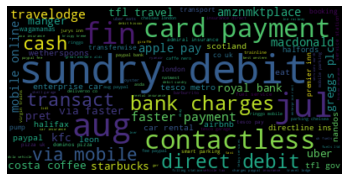

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Start with one review:

xx = []
for i in data['bank_transaction_description']:
    xx.append(i)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(",".join(xx))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Plot categories 

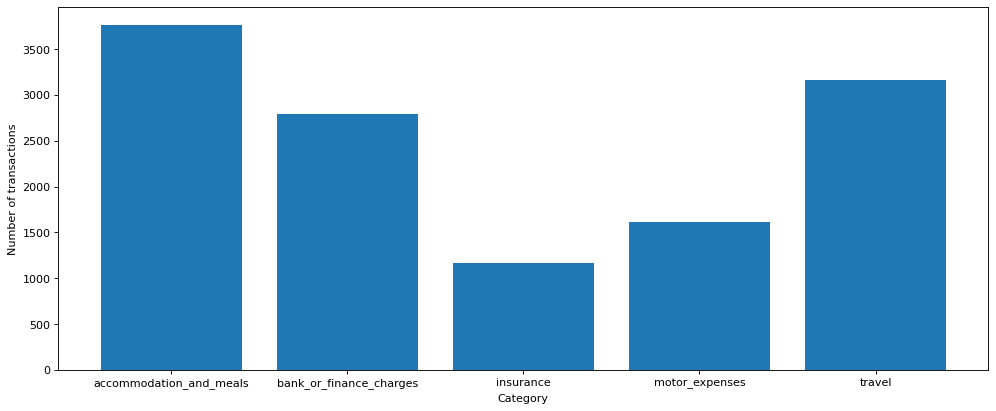

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=80)


catcount = data.groupby('category').count()
plt.bar(catcount.index.values, catcount['bank_transaction_description'])
plt.xlabel('Category')
plt.ylabel('Number of transactions')
plt.show()



Vectorize description using count vectorization technique 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer #Import Count Vectorizer


cv = CountVectorizer()
tfid = TfidfVectorizer()
from sklearn.model_selection import train_test_split #Cross Validation 
train, valid = train_test_split(data, test_size=0.2) #split train and valid set 80/20


train_set= cv.fit_transform(train['bank_transaction_description'])
train_tag = train['category']
valid_set= cv.transform(valid['bank_transaction_description'])
valid_tag = valid['category']



vocab = cv.get_feature_names()

In [ ]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDClassifier(max_iter=5,random_state=20,n_jobs=50, average = True, power_t =2, n_iter_no_change =1)
clf2.fit(train_set, train_tag)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(average=True, max_iter=5, n_iter_no_change=1, n_jobs=50,
              power_t=2, random_state=20)

In [ ]:
sgd_train = clf2.predict(train_set)

print('Train accuracy = {}'.format(
        accuracy_score(sgd_train , train_tag) * 100)
     )
f1_score = metrics.f1_score(sgd_train, train_tag, average='macro')
print(' F1 Train classification score: {}'.format(f1_score* 100))

sgd_test= clf2.predict(valid_set)

print('Test accuracy = {}'.format(
        accuracy_score(sgd_test, valid_tag) * 100)
     )
f1_score = metrics.f1_score(sgd_test, valid_tag, average='macro')
print(' F1 Test classification score: {}'.format(f1_score* 100))

Train accuracy = 93.5
 F1 Train classification score: 92.87249909978486
Test accuracy = 93.04
 F1 Test classification score: 92.52556530047163


In [ ]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators=2000, random_state=2, max_dept = 4)

xgb= clf.fit(train_set, train_tag,
        verbose=True)

/root/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[23:02:46] WARNING: ../src/learner.cc:573: 
Parameters: { "max_dept" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:02:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd l

KeyboardInterrupt: 

In [ ]:
xgb_train = xgb.predict(train_set)

print('Train accuracy = {}'.format(
        accuracy_score(xgb_train , train_tag) * 100)
     )
f1_score = metrics.f1_score(xgb_train, train_tag, average='macro')
print(' F1 Train classification score: {}'.format(f1_score* 100))

xgb_test= xgb.predict(valid_set)

print('Test accuracy = {}'.format(
        accuracy_score(xgb_test, valid_tag) * 100)
     )
f1_score = metrics.f1_score(xgb_test, valid_tag, average='macro')
print(' F1 Test classification score: {}'.format(f1_score* 100))

Train accuracy = 95.66
 F1 Train classification score: 95.38230332015915
Test accuracy = 92.64
 F1 Test classification score: 91.87015179513537


In [ ]:
!pip install xgboost==1.4.2

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


save model for inference 

In [ ]:
import pickle
from joblib import dump, load 


#save vocabulary 
dump(vocab, "vocab.joblib.dat")
dump(xgb, "model.joblib.dat")


In [ ]:
loaded_model = load("model.joblib.dat")
print("Loaded model from: pima.joblib.dat")

Loaded model from: pima.joblib.dat


Test an inference data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer #Import Count Vectorizer
import numpy as np

import re

def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)
    
  return input_txt


cv = CountVectorizer(min_df=0, lowercase=True,vocabulary = vocab)

custom = ['nibiss Instant Payment Outward Yusuf Money TO fcmb oladinma khajid']#Shanti Toh has become angry

text = np.vectorize(remove_pattern)(custom, "@[\w]*")



In [ ]:

#tfid.fit(text)
pred_text = cv.transform(text)
#print(pred_text)
#prediction_random
#pred_text = tfid.transform(text)
prediction_random= loaded_model.predict(pred_text)
prediction_random

In [ ]:
import requests

url = "http://172.3.186.64:8080/mono_transapi"

payload={'text': "nibiss Instant Payment Outward Yusuf Money TO fcmb oladinma khajid"}

headers = {}

response = requests.request("POST", url, headers=headers, data=payload)

print(response.text)

motor_expenses


In [ ]:
t = load_predict(["nibiss Instant Payment Outward Yusuf Money TO fcmb oladinma khajid"])

In [ ]:
t

'motor_expenses'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3225b5b1-dc61-40e7-9ee3-2b14ff423dfe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>